In [21]:
import os
import numpy as np 

from plot_params import * 
from math import sqrt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import qmc

In [22]:
# define global functions

def check_inside_mandlebrot(i, c):
    z = 0 + 0j
    for i in range(i):
        z = z ** 2 + c
        if abs(z) > 2:
            return False
    return True

def mandlebrot_area(i, s, sampling_function):
    random_complex_numbers = sampling_function(s)
    in_mandlebrot = 0
    for z in random_complex_numbers:
        if check_inside_mandlebrot(i, z):
            in_mandlebrot += 1
    area = in_mandlebrot / s * area_box
    return area

def uniform_samples(n):
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = np.random.uniform(imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers

def OLHC_samples(n):
    M = int(np.sqrt(n))
    scale = 4/n
    x = np.empty(shape=(M,M))
    y = np.empty(shape=(M,M))
    m = 0
    samples = np.empty(n,dtype=np.complex_)
    for i in range(M):
        for j in range(M):
            m = m + 1
            x[i,j] = m
            y[i,j] = m
            
    for i in range(M):
        x[:,i] = permute(x[:,i],M)
        y[:,i] = permute(y[:,i],M)
 
    for i in range(M):
        for j in range(M):
            reals = -2 + scale*(x[i,j] + np.random.random(1))
            imags = -2 + scale*(y[i,j] + np.random.random(1))
            samples[M*i+j] = reals + imags*1j
    return samples

def permute(x, N):
    for i in reversed(range(1,N-1)):
        h = x[i]
        r = np.random.randint(N)
        x[i] = x[r]
        x[r] = h
    return x

def LHC_samples(n):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n) 
    sample = qmc.scale(sample, [real_min, imag_min], [real_max, imag_max])

    reals = sample[:, 0]
    imags = sample[:, 1]

    samples = reals + imags * 1j
    return samples


In [23]:
class DetermineNumberRuns():
    def __init__(self, n_samples, default_i, interval_length, z_value, rand_num_generator):
        self.n_samples = n_samples
        self.default_i = default_i
        self.interval_length = interval_length
        self.z_value = z_value
        self.rand_num_generator = rand_num_generator

        self.all_areas = []
        self.all_sample_means = []
        self.all_stop_checks = []
        self.all_k_at_check = []

        self.k = 1
        self.sample_mean = 0
        self.sample_var = 0
        self.sample_std = 0
    
    def generate_new_values(self, n_values):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(self.default_i, self.n_samples, self.rand_num_generator) for _ in range(n_values))
        self.all_areas = self.all_areas + areas

        for area in areas:
            new_sample_mean = self.sample_mean + (area - self.sample_mean) / (self.k + 1)
            self.sample_var = (1 - 1 / self.k) * self.sample_var + (self.k + 1) * (new_sample_mean - self.sample_mean) ** 2
            self.sample_mean = new_sample_mean
            self.sample_std = sqrt(self.sample_var)
            self.k += 1
        self.all_sample_means.append(self.sample_mean)

    def keep_going(self):
        check = 2 * self.z_value * self.sample_std / sqrt(self.k)
        self.all_stop_checks.append(check)
        self.all_k_at_check.append(self.k)
        return check > self.interval_length
    

In [24]:
# see how fast the area converges based on the number of iterations

class IterationConvergence():
    def __init__(self, max_i, n_samples, n_runs, rand_num_generator, n_different_i):
        self.max_i = max_i
        self.n_samples = n_samples
        self.n_runs = n_runs
        self.rand_num_generator = rand_num_generator
        self.means = np.zeros(n_different_i)
        self.stds = np.zeros(n_different_i)
        self.max_mean, self.max_std = self.determine_area(max_i)

    def determine_area(self, i):
        areas = Parallel(n_jobs=n_cores)(delayed(mandlebrot_area)(i, self.n_samples, self.rand_num_generator) for _ in range(self.n_runs))
        areas = np.array(areas)
        mean = areas.mean()
        std = areas.std() / sqrt(self.n_runs)
        return mean, std
    
    def dist_from_max(self, i):
        mean, std = self.determine_area(i)
        mean_diff = mean - self.max_mean
        std_diff = std + self.max_std
        return mean_diff, std_diff


In [25]:
# sampling area
real_min = -2
real_max = 0.46
imag_min = -1.12
imag_max = 1.12
area_box = (real_max - real_min) * (imag_max - imag_min)

# settings 
n_cores = os.cpu_count()
rand_num_generator = uniform_samples
n_samples = 5000
interval_length = 0.01
z_value = 1.96
n_init_runs = 100
n_different_i = 10
min_i = 100
max_i = 500
i_values = np.linspace(max_i, min_i, n_different_i, dtype=int)
means = np.zeros(n_different_i)
stds = np.zeros(n_different_i)

In [26]:
dnr_results = []
dnr_k = []
ic_mean_results = []
ic_std_results = []

for rand_num_generator in [uniform_samples, LHC_samples, OLHC_samples]:

    # determine how many runs we need in order to achieve satiffactory accuracy
    dnr = DetermineNumberRuns(n_samples, min_i, interval_length, z_value, rand_num_generator)
    dnr.generate_new_values(n_init_runs)
    while dnr.keep_going():
        dnr.generate_new_values(n_cores)
    print(f'{dnr.k} runs needed')
    dnr_results.append(dnr.all_stop_checks)
    dnr_k.append(dnr.all_k_at_check)

    # check how quickly the area converges when increasing the number of iterations i
    ic = IterationConvergence(max_i, n_samples, dnr.k, rand_num_generator, n_different_i)
    for i in tqdm(range(n_different_i)):
        ic.means[i], ic.stds[i] = ic.dist_from_max(i_values[i])
    ic_mean_results.append(ic.means)
    ic_std_results.append(ic.stds)

725 runs needed


100%|██████████| 10/10 [09:51<00:00, 59.15s/it]


641 runs needed


100%|██████████| 10/10 [08:58<00:00, 53.81s/it]


377 runs needed


100%|██████████| 10/10 [03:57<00:00, 23.78s/it]


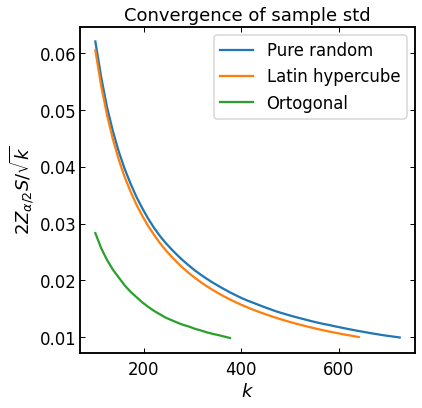

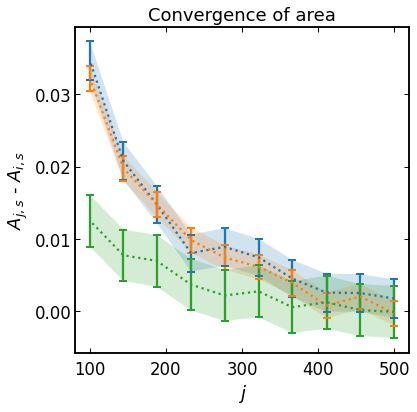

In [53]:

plt.plot(dnr_k[0], dnr_results[0], label='Pure random')
plt.plot(dnr_k[1], dnr_results[1], label='Latin hypercube')
plt.plot(dnr_k[2], dnr_results[2], label='Ortogonal')
plt.legend()
plt.title('Convergence of sample std')
plt.ylabel(r'$2 Z_{\alpha / 2} S / \sqrt{k}$')
plt.xlabel('$k$')
plt.show()

plt.errorbar(i_values, ic_mean_results[0], ic_std_results[0], fmt=':', capsize=4, capthick=2)
plt.fill_between(i_values, ic_mean_results[0] - ic_std_results[0], ic_mean_results[0] + ic_std_results[0], alpha=0.2)
plt.errorbar(i_values, ic_mean_results[1], ic_std_results[1], fmt=':', capsize=4, capthick=2)
plt.fill_between(i_values, ic_mean_results[1] - ic_std_results[1], ic_mean_results[1] + ic_std_results[1], alpha=0.2)
plt.errorbar(i_values, ic_mean_results[2], ic_std_results[2], fmt=':', capsize=4, capthick=2)
plt.fill_between(i_values, ic_mean_results[2] - ic_std_results[2], ic_mean_results[2] + ic_std_results[2], alpha=0.2)
plt.title('Convergence of area')
plt.xlabel('$j$')
plt.ylabel('$A_{j, s}$ - $A_{i, s}$')
plt.show()

In [ ]:
# write own latin hypercude
# rewrite for easy variation of sampling function
# clean up code with helpers.py